# Injections

# Initializations

In [1]:
import ringdown
from ringdb import Database
import json
import pandas as pd
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set up database
data_folder = "./Data" # Folder where the downloaded strain data is saved
alternative_data_folder = "./AlternativeData" # Folder where the strain is saved

db = Database(data_folder)
db.initialize()

db.update_posterior_schema({'f_low': {'path': "/{approximant}/meta_data/meta_data/f_low", 'type':'value'}})
db.update_posterior_schema({'f_ref': {'path': "/{approximant}/meta_data/meta_data/f_ref", 'type':'value'}})

# Define functions
def get_target(eventname, N_samps=None, target_sample_rate=4096, f_low=20, f_ref=20, q=0.5):
    """
    Calculates the sky location and start time that will be chosen for the fit object. 
    This function will 
    1. randomly get a subset posterior samples (of size `N_samps`)
    2. calculate the geocenter peak strain for each of the posterior samples
    3. choose the `q`-th quantile (i.e. `q*100`-th percentile) sample and package its t0, ra, dec and psi 
    
    
    Parameters
    -----------
    eventname : str
        The name of the event e.g. "GW150914"
    N_samps : int
        This many samples will be chosen from the posterior for the actual analysis. Some IMR posteriors have too many samples.
        Defaults to using all samples
    target_sample_rate : float
        The waveform generator will use this sample rate when generating waveforms
    f_low : float (default : 20)
        f_low
    f_ref : float (default : 20)
        reference frequency
    q :  float (default : 0.5)
        The chosen sample for the target will be the one which lands on the `q`-th quantile when ordered by the geocent peak time. 
        
        
    Returns
    --------
    args : Dict with keys 't0', 'ra', 'dec' and 'psi' 
        This is a dictionary of the chosen target parameters.
    median_samp : pd.Series
        This is the chosen median sample. Returned if any other parameters like final_mass and final_spin are needed. 
    samps : pd.DataFrame
        A dataframe of all the samples that were chosen for calculation and their corresponding peak times at each ifo.
    
    """
    event = db.event(eventname)
    strains = event.strain()
    posts = event.posteriors()

    N_samps = N_samps or len(posts)

    try:
        f_low = float(event.read_posterior_file_from_schema('f_low'))
        f_ref = float(event.read_posterior_file_from_schema('f_ref'))
        print(f"f_low is set to {f_low}")
        print(f"f_ref is set to {f_ref}")
        waveform_name = posts['waveform_name'].unique()[0]
        waveform_code = int(posts['waveform_code'].unique()[0])
    except:
        print("Falling back to f_ref = 20, f_low=20")
        waveform_name = posts['waveform_name'].unique()[0]
        waveform_code = int(posts['waveform_code'].unique()[0])
        f_low = f_low
        f_ref = f_ref


    print(f"Using {waveform_name}")
    wf_ls = waveform_code
    sample_rate = np.max([a.fsamp for a in strains.values()])


    samps = [x.to_dict() for i,x in posts.sample(N_samps).iterrows()]

    for i,x in enumerate(samps):
        t_peak, t_dict, hp, hc = ringdown.complex_strain_peak_time_td(x,
                                                                      wf=wf_ls, dt=1/target_sample_rate,
                                                                      f_ref=f_ref, f_low=f_low)
        samps[i].update({k+'_peak':v for k,v in t_dict.items()})

    samps = pd.DataFrame(samps)

    # Get median sample
    ref_ifo = 'H1'
    im = (samps[f'{ref_ifo}_peak'] - samps[f'{ref_ifo}_peak'].quantile(q)).abs().argmin()
    median_samp = samps.iloc[im]

    # Construct Arguments for set_target
    args = median_samp[['geocent_peak', 'ra','dec','psi']].rename({'geocent_peak':'t0'}).to_dict()
    print("The median time at H1 is: ", median_samp['H1_peak'], "s")

    # Get the mass time-scale
    Mass_Time = lambda M: 6.674e-11*M*1.989e+30/(3e8)**3
    t_M = Mass_Time(median_samp['final_mass'])
    print("The mass time-scale is: ", np.round(t_M*1000,3), "ms")

    times_above_below = (samps['H1_peak'].quantile(0.95) - samps['H1_peak'].quantile(0.05))/(2*t_M)
    print(f"The 90% CI of H1 peak time is +/- {np.round(times_above_below,1)} t_M")

    return args, median_samp, samps



def set_fit(eventname, target, mass_for_prior, duration=0.1, target_sample_rate=4096, model='mchiq_exact', modes=[(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)], cond_kws = None, **model_kwargs):

    '''
    The convention for modes is (prograde, s, l, m, n)
    The options for models are mchi, mchiq, and mchiq_exact. 
    mchiq is for all beyond-GR EVP applications.
    You can change the beyon-GR model using the kwargs, which get passed to ringdown.Fit
    The coefficients must be created by fitting EVP data as a separate step.
    df_coeffs = [[a0,a1,a2,a3...],[a0,a1,a2,a3...],..]; n_modes x n_coeffs for the frequency shifts
    dg_coeffs = (similar structure as df) for the decay rate shifts
    '''
    
    event = db.event(eventname)
    strains = event.strain()
    #load_data_dict = SFM.load_data_dict(eventname, ifos=list(strains.keys()))
    
    #Hacking in ability to change amplitude priors:
    Aprior = model_kwargs.pop('flat_A',1)
    
    fit = ringdown.Fit(model=model, modes=modes, **model_kwargs)
    
    #fit.load_data(load_data_dict, kind="gwosc")
    
    for ifo in strains.keys():
        fit.add_data(strains[ifo])
        
    sample_rate = np.max([f.fsamp for f in strains.values()])

    fit.set_target(**target, duration=duration)
    
    #Adding a cond kwargs to allow us to low pass or add other conditioning arguments
    default_kws = dict(digital_filter=True)
    default_kws.update(cond_kws or {})
    
    #Revisit the trim = 0 setting. Why was this done? Naively this should be set to a nonzero value

    fit.condition_data(ds=int(sample_rate/target_sample_rate),**default_kws)
    fit.compute_acfs()

    #fit.update_prior(A_scale=5e-21, M_min=mass_for_prior*0.5,
    #                 M_max=mass_for_prior*2.0,
    #                 flat_A=1)
    fit.update_prior(A_scale=5e-21, M_min=mass_for_prior*0.5,
                     M_max=mass_for_prior*2.0,
                     flat_A=1)
    return fit



In [2]:
eventname = "GW150914" # Name of the event

args, median_samp, samps = get_target(eventname=eventname,  # name of the event
                                      N_samps=8000, # size posterior samples subset used for this computation  
                                      q=0.5)        # the sample with the q*100 % percentile sample is picked out) 

f_low is set to 20.0
f_ref is set to 20.0
Using IMRPhenomXPHM
The median time at H1 is:  1126259462.424098 s
The mass time-scale is:  0.334 ms
The 90% CI of H1 peak time is +/- 4.8 t_M


# Playing with PSDs

In [90]:
eventname = "GW150914"
event = db.event(eventname)

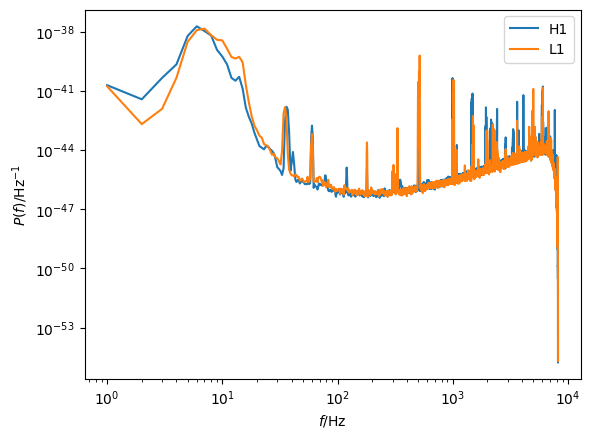

In [91]:
event.strain()['H1'].get_psd(nperseg=16384).iloc[1:].plot(label='H1')
event.strain()['L1'].get_psd(nperseg=16384).iloc[1:].plot(label='L1')
plt.xlabel(r'$f / \mathrm{Hz}$');
plt.ylabel(r'$P\left( f \right) / \mathrm{Hz}^{-1}$');
plt.xscale('log');
plt.yscale('log');
plt.legend(loc='best');

### Lets try out the different ways of getting the PSD

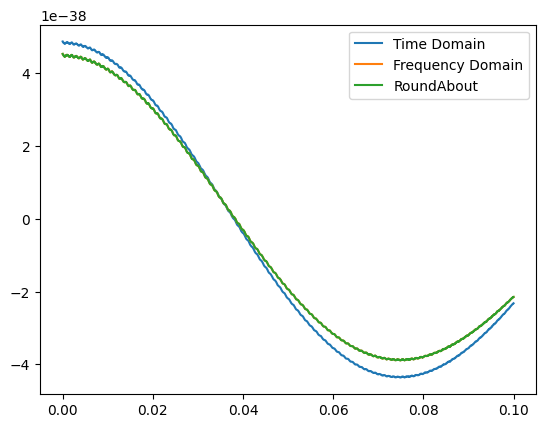

In [92]:
event.strain()["H1"].get_acf(method='td')[0:0.1].plot(label='Time Domain')
event.strain()["H1"].get_acf(method='fd')[0:0.1].plot(label='Frequency Domain')
event.strain()["H1"].get_psd(nperseg=2**14).to_acf()[0:0.1].plot(label='RoundAbout')
plt.legend(loc='best');

### A plot of the cholesky matrix

In [175]:
theacf = event.strain()["H1"].get_acf(method='fd')[0:1]
theacf = theacf/((theacf**2).sum()**(1/2))
L = theacf.cholesky
#t_ind = theacf.index.values
#plt.imshow(np.log(L))
#plt.colorbar()

Lets create some white noise:

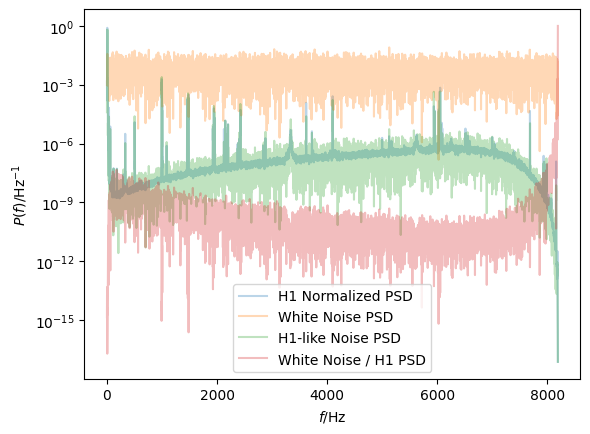

In [193]:
H1_noise_psd = event.strain()["H1"].get_psd(nperseg=2**14)
#.get_psd(nperseg=2**14)
H1_noise_psd = H1_noise_psd/((H1_noise_psd**2).sum()**(1/2))
H1_noise_psd.plot(label="H1 Normalized PSD", alpha=0.3)

t_ind = np.arange(0.0, 1.0, event.strain()["H1"].delta_t)
white_noise = ringdown.Data(np.random.randn(t_ind.shape[0]), index=t_ind , ifo="H1")
white_noise_psd = white_noise.get_psd()
white_noise_psd = white_noise_psd/np.sqrt((white_noise_psd**2).sum())
white_noise_psd.plot(label="White Noise PSD", alpha=0.3)

detector_noise_vals = L@white_noise.values
detector_noise = ringdown.Data(detector_noise_vals, index=t_ind , ifo="H1")
detector_noise_psd = detector_noise.get_psd()
detector_noise_psd = detector_noise_psd/np.sqrt((detector_noise_psd**2).sum())
detector_noise_psd.plot(label="H1-like Noise PSD", alpha=0.3)

divided_spectrum_psd = white_noise_psd/H1_noise_psd
divided_spectrum_psd = divided_spectrum_psd/np.sqrt((divided_spectrum_psd**2).sum())
divided_spectrum_psd.plot(label="White Noise / H1 PSD", alpha=0.3)


plt.xlabel(r'$f / \mathrm{Hz}$');
plt.ylabel(r'$P\left( f \right) / \mathrm{Hz}^{-1}$');
#plt.xscale('log');
plt.yscale('log');
plt.legend(loc='best');

In [602]:
testfit = set_fit(eventname, args, median_samp["final_mass"],duration=0.05)

In [603]:
testfit.run()

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, r2_qchi, theta_qchi, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, r2_qchi, theta_qchi, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 372 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 372 seconds.


In [604]:
from scripts import *

In [607]:
cp = Posterior.ChargedPosterior

# Simple damped sinosoid analysis

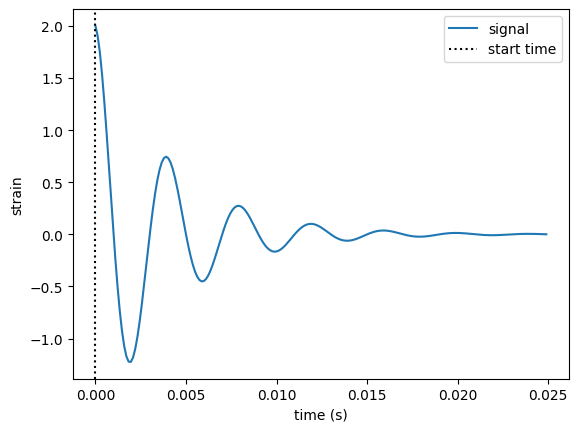

In [544]:
from pylab import *
import ringdown as rd

# define sampling rate and duration (make these powers of two)
fsamp = 8192 #2**(14-2)
duration = 0.05
t0 = 0

delta_t = 1/fsamp
tlen = int(round(duration / delta_t))
epoch = t0 - 0.5*tlen*delta_t

time = np.arange(tlen)*delta_t + epoch


wf_kws = dict(
    A = 2,
    phi = 0,
    f = 250,
    gamma = 250,
)

def get_signal(time, A, phi, f, gamma):
    s = A*cos(2*np.pi*f*(time-t0) + phi)*exp(-gamma*abs(time-t0))
    return rd.Data(s, index=time)

signal = get_signal(time, **wf_kws)
signal = signal[0:len(signal)]

signal.plot(label='signal')
axvline(t0, ls=':', c='k', label='start time')
#xlim(-0.0, 0.05)
xlabel('time (s)')
ylabel('strain')
legend();

In [545]:
#rng = np.random.default_rng(12345)
data = signal
data

0.000000    2.000000
0.000122    1.904334
0.000244    1.744907
0.000366    1.531307
0.000488    1.274528
              ...   
0.024414    0.003557
0.024536    0.002887
0.024658    0.002151
0.024780    0.001380
0.024902    0.000605
Length: 205, dtype: float64

<AxesSubplot: >

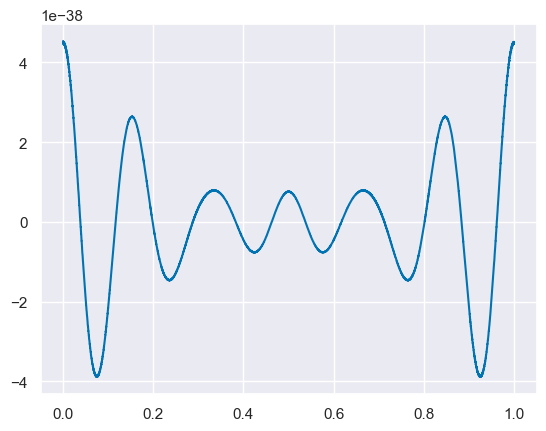

In [591]:
event.strain()["H1"].get_acf().plot()

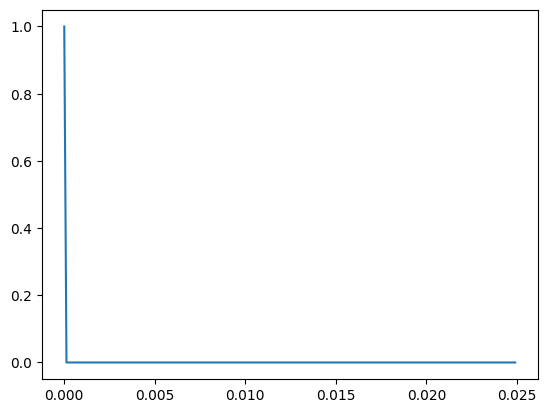

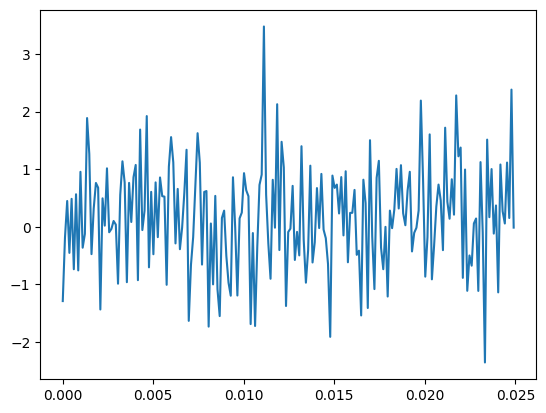

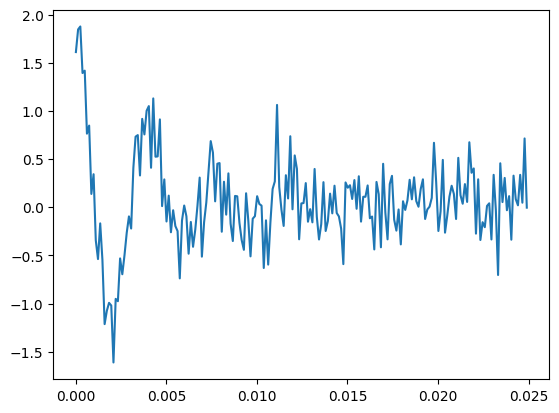

In [546]:
H1_s = event.strain()["H1"]
#H1_s/np.sqrt((H1_s**2).sum())
#noise_acf = H1_s.condition(ds=4, digital_filter=True).get_acf().iloc[0:len(signal)]
#noise_acf.plot()

noise_acf = ringdown.AutoCovariance(np.zeros_like(signal.values), delta_t=signal.delta_t)
noise_acf.iloc[0] = 1
noise_acf.plot()
plt.show()
L = noise_acf.cholesky
#L_norm = L@np.ones(L.shape[0])
#L_norm = np.sqrt((L_norm**2).sum())
#L = 100*L/(L_norm)
noise_new = np.random.multivariate_normal(mean=np.zeros(len(signal)), cov=L@L.transpose())
noise_new = rd.Data(noise_new, signal.index)
noise_new.plot()
plt.show()

data = signal + 0.3*noise_new

data.plot()
plt.show()

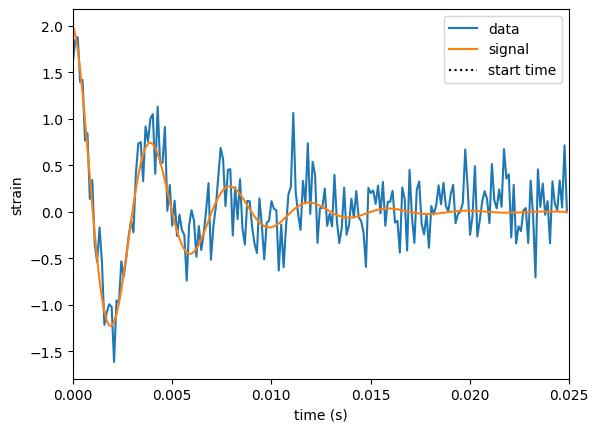

In [547]:
data.plot(label='data')
signal.plot(label='signal')
axvline(t0, ls=':', c='k', label='start time')
xlim(0.00, 0.025)
xlabel('time (s)')
ylabel('strain')
legend();

/Users/asadh/Documents/GitHub/ringdown-CLI/environments/notebook-venv/lib/python3.8/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 8192 is greater than input length  = 205, using nperseg = 205
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/asadh/Documents/GitHub/ringdown-CLI/environments/notebook-venv/lib/python3.8/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 8192 is greater than input length  = 205, using nperseg = 205
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/asadh/Documents/GitHub/ringdown-CLI/environments/notebook-venv/lib/python3.8/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 8192 is greater than input length  = 205, using nperseg = 205
  warnings.warn('nperseg = {0:d} is greater than input length '


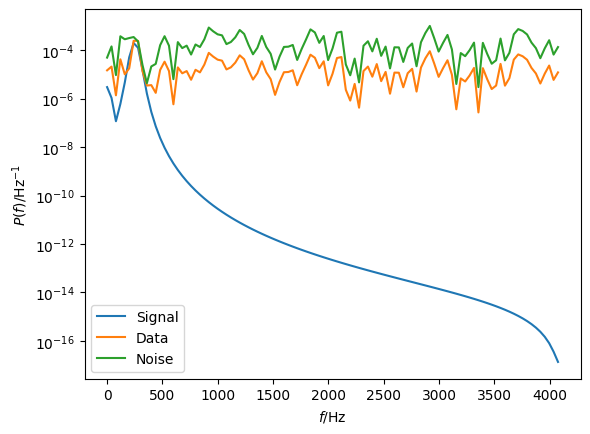

In [548]:
signal.get_psd().plot(label="Signal")
data.get_psd().plot(label="Data")
noise_new.get_psd().plot(label="Noise")
plt.yscale('log')
plt.xlabel(r'$f / \mathrm{Hz}$');
plt.ylabel(r'$P\left( f \right) / \mathrm{Hz}^{-1}$');
plt.legend(loc='best')

# Make Fit object

In [550]:
fit = ringdown.Fit('ftau', 1, ifo='X')

fit.add_data(data, acf=noise_acf, ifo='X')
fit.set_target(data.index[0], duration=0.03)
fit.update_prior(A_scale=5, f_min=50, f_max=500, gamma_min=50, gamma_max=500)
fit.prior_settings

{'A_scale': 5,
 'f_max': 500,
 'f_min': 50,
 'gamma_max': 500,
 'gamma_min': 50,
 'ifo': 'X'}

In [551]:
fit.run()

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f, gamma, Ax_unit, Ay_unit]
INFO:pymc:NUTS: [f, gamma, Ax_unit, Ay_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [552]:
az.summary(fit.result, var_names=['A', 'phi', 'f', 'tau'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A[0],1.929,0.449,1.099,2.773,0.010,0.007,1983.0,2096.0,1.0
phi[0],0.106,0.326,-0.495,0.702,0.008,0.006,1534.0,1364.0,1.0
f[0],254.195,21.869,207.615,291.012,0.703,0.511,1238.0,1047.0,1.0
tau[0],0.004,0.001,0.002,0.006,0.000,0.000,1367.0,1641.0,1.0


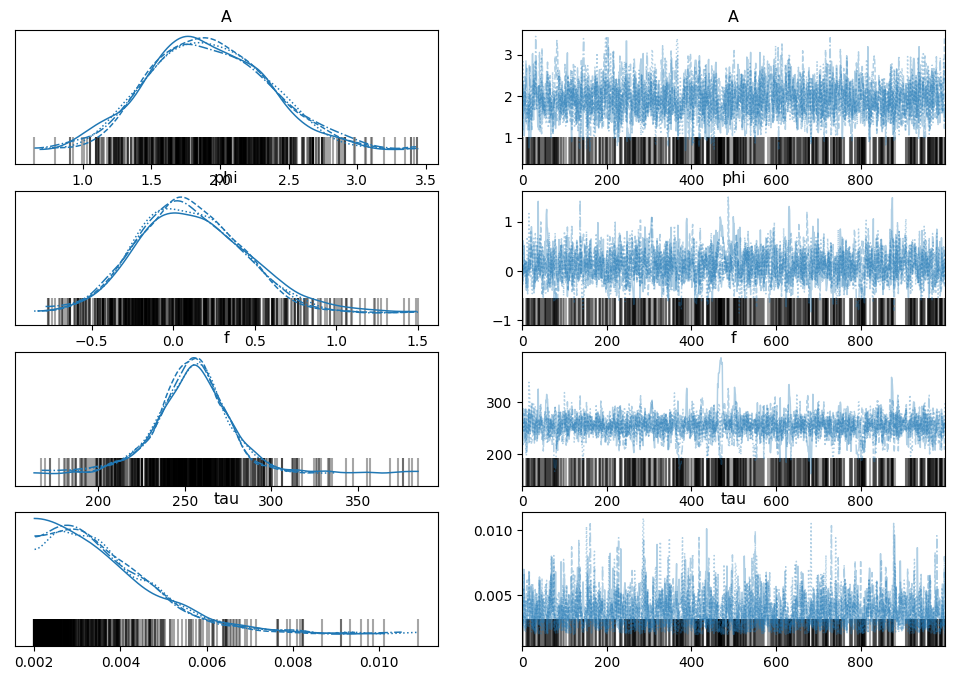

In [553]:
az.plot_trace(fit.result, var_names=['A', 'phi', 'f', 'tau'], compact=True);

In [542]:
noise

0.000000    5.001821e-38
0.000244    4.967737e-38
0.000488    4.944381e-38
0.000732    4.969325e-38
0.000977    4.987135e-38
                ...     
0.023682    2.837795e-38
0.023926    2.825645e-38
0.024170    2.797661e-38
0.024414    2.729854e-38
0.024658    2.672828e-38
Length: 102, dtype: float64

<AxesSubplot: >

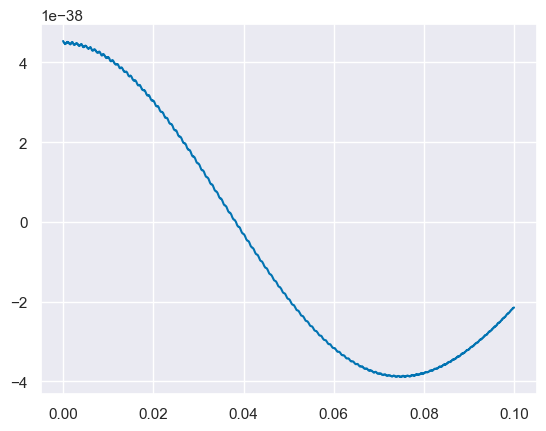

In [580]:
event.strain()['H1'].get_psd(nperseg=16384).to_acf()[0:0.1].plot()

# Vanilla run to debug

In [ ]:
from pylab import *
import arviz as az
import seaborn as sns
import pandas as pd
import ringdown as rd

sns.set(context='notebook', palette='colorblind')


# define sampling rate and duration (make these powers of two)
fsamp = 8192
duration = 4
t0 = 0

delta_t = 1/fsamp
tlen = int(round(duration / delta_t))
epoch = t0 - 0.5*tlen*delta_t

time = np.arange(tlen)*delta_t + epoch

wf_kws = dict(
    A = 2,
    phi = 0,
    f = 250,
    gamma = 250,
)

def get_signal(time, A, phi, f, gamma):
    s = A*cos(2*np.pi*f*(time-t0) + phi)*exp(-gamma*abs(time-t0))
    return rd.Data(s, index=time)

signal = get_signal(time, **wf_kws)

signal.plot(label='signal')
axvline(t0, ls=':', c='k', label='start time')
xlim(-0.03, 0.03)
xlabel('time (s)')
ylabel('strain')
legend();

plt.show()

#acf = rd.AutoCovariance(zeros_like(data), delta_t=data.delta_t)
#acf.iloc[0] = 1

L = acf.cholesky

#rng = np.random.default_rng(12345)
data = signal + np.random.multivariate_normal(mean=zeros_like(acf.values),cov=L@L.transpose())
#rng.normal(0, 1, len(signal))

data.plot(label='data')
signal.plot(label='signal')
axvline(t0, ls=':', c='k', label='start time')
xlim(-0.03, 0.03)
xlabel('time (s)')
ylabel('strain')
legend();

plt.show()

fit = rd.Fit('ftau', modes=1)
fit.add_data(data, ifo='X')
fit.set_target(t0, duration=0.05)
fit.update_prior(A_scale=5, f_min=50, f_max=500, gamma_min=50, gamma_max=500)
fit.prior_settings

In [559]:
fit.run()

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f, gamma, Ax_unit, Ay_unit]
INFO:pymc:NUTS: [f, gamma, Ax_unit, Ay_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


In [560]:
az.summary(fit.result, var_names=['A', 'phi', 'f', 'tau'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A[0],2.374,0.470,1.567,3.341,0.009,0.006,3135.0,2514.0,1.0
phi[0],-0.197,0.253,-0.623,0.299,0.005,0.003,2945.0,2530.0,1.0
f[0],240.274,13.878,215.039,264.641,0.263,0.186,2817.0,2487.0,1.0
tau[0],0.005,0.001,0.003,0.007,0.000,0.000,2729.0,1954.0,1.0


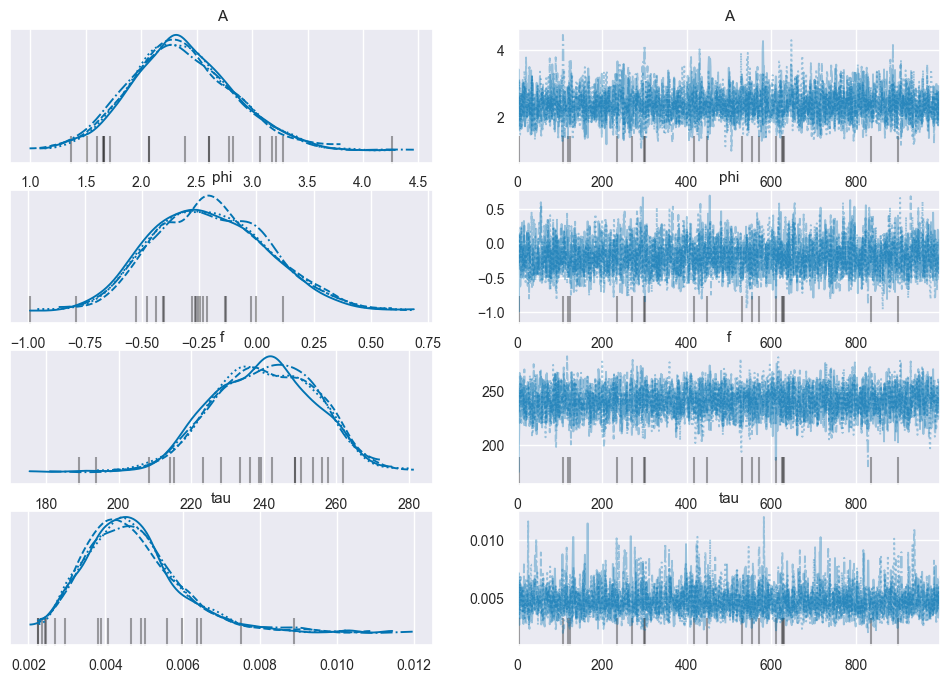

In [561]:
az.plot_trace(fit.result, var_names=['A', 'phi', 'f', 'tau'], compact=True);

In [85]:
def f_tau_plot(result):
    df = pd.DataFrame({
        #r'$A$': fit.result.posterior.A.values.flatten(),
        #r'$\phi$': fit.result.posterior.phi.values.flatten(),
        r'$f / \mathrm{Hz}$': result.posterior.f.values.flatten(),
        r'$\gamma  / \mathrm{Hz}$': result.posterior.gamma.values.flatten()
    })
    pg = sns.PairGrid(df, diag_sharey=False, corner=True)
    pg.map_diag(sns.kdeplot);
    pg.map_lower(sns.scatterplot, marker='.', alpha=0.02);
    pg.map_lower(rd.kdeplot_2d_clevels, levels=[0.9, 0.5, 0.1]);

    true_vals = [250, 250]
    
    flim = [100,400]
    taulim = [100,500]
    
    pg.axes[0,0].set_xlim(flim)
    pg.axes[1,0].set_xlim(flim)
    pg.axes[1,0].set_ylim(taulim)
    pg.axes[1,1].set_xlim(taulim)

    # plot true values
    for i, vi in enumerate(true_vals):
        for j, vj in enumerate(true_vals):
            if i >= j:
                pg.axes[i,j].axvline(vj, ls=':')
                pg.axes[i,j].set_xlim()
                if i != j:
                    pg.axes[i,j].axhline(vi, ls=':')
                    
    return pg

In [594]:
wf_kws

{'A': 2, 'phi': 0, 'f': 250, 'gamma': 250}

In [99]:
import glob

files = [g for g in glob.glob("./SimpleRunResultsImproved/*.nc")]
results = []
for i in range(len(files)):
    results.append(az.from_netcdf(f"./SimpleRunResultsImproved/run{i}.nc"))

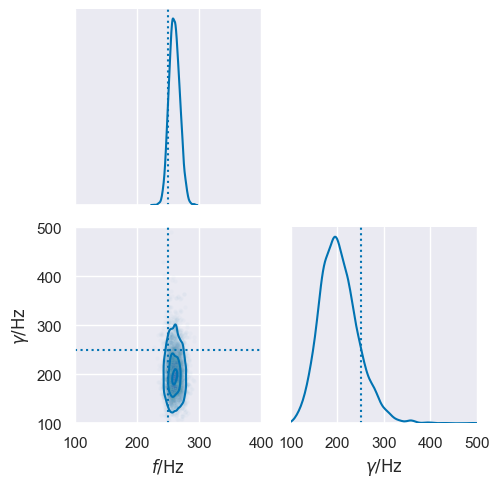

In [101]:
pg = f_tau_plot(results[np.random.randint(len(results))])
plt.show()

In [104]:
import os 

temp_folder = "./temp"
gif_name = "ftau_ensemble_improved"

(not os.path.exists(temp_folder)) and os.mkdir(temp_folder)

def create_anim(filename, folder="./temp", duration=800):
    # Create the frames
    frames = []
    imgs = glob.glob(f"{folder}/*.png")
    imgs.sort()
    for i in imgs:
        new_frame = Image.open(i)
        frames.append(new_frame)

    # Save into a GIF file that loops forever
    frames[0].save(f'{filename}.gif', format='GIF',
                   append_images=frames[1:],
                   save_all=True,
                   duration=duration, loop=0)
    
    return imgs


for i in range(len(results)):
    print(i)
    pg = f_tau_plot(results[i])
    pg.fig.suptitle(f"Run {i}")
    pg.fig.savefig(f"{temp_folder}/img{i}.png")
    plt.close(pg.fig)
    del pg

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [105]:
from PIL import Image
frames = []
imgs = [f"{temp_folder}/img{i}.png" for i in range(len(results))]
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save(f'{gif_name}.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=200, loop=0)

In [622]:
az.summary(results[4], var_names=['f','gamma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
f[0],288.99,29.834,239.026,339.310,0.83,0.587,1326.0,2282.0,1.0
gamma[0],303.17,86.128,158.604,471.987,2.30,1.626,1338.0,1244.0,1.0


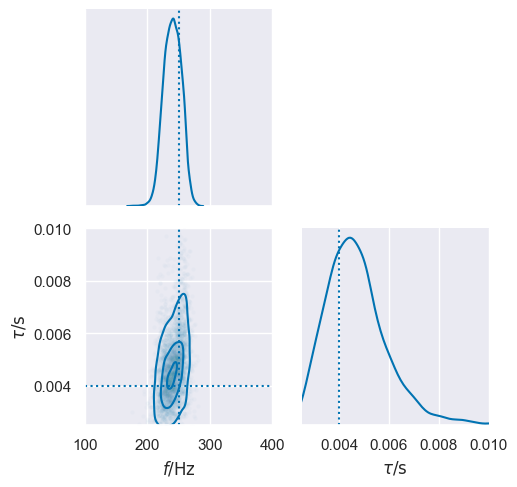

In [636]:
pg.fig

In [835]:
thestrain = event.strain()["H1"]
acf_new = thestrain.get_psd(nperseg=thestrain.fsamp*4).to_acf()
LL = acf_new[0:0.1].cholesky

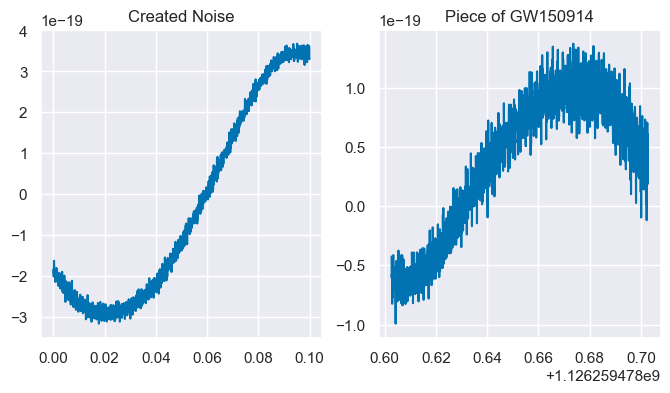

In [970]:
fig1, axs = plt.subplots(ncols=2, figsize=(8,4))
axs[0].plot(np.linspace(0,0.1,LL.shape[0]), LL@np.random.normal(np.zeros(LL.shape[0])))
axs[0].set_title("Created Noise")
t00 = thestrain.time[np.random.randint(len(thestrain))]
thestrain[t00:(t00 + 0.1)].plot(ax=axs[1])
axs[1].set_title("Piece of GW150914")
plt.show()

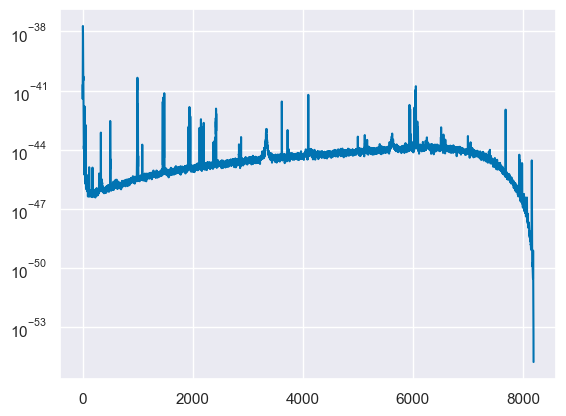

In [856]:
thestrain.get_psd(nperseg=thestrain.fsamp).iloc[1:].plot()
plt.yscale('log')

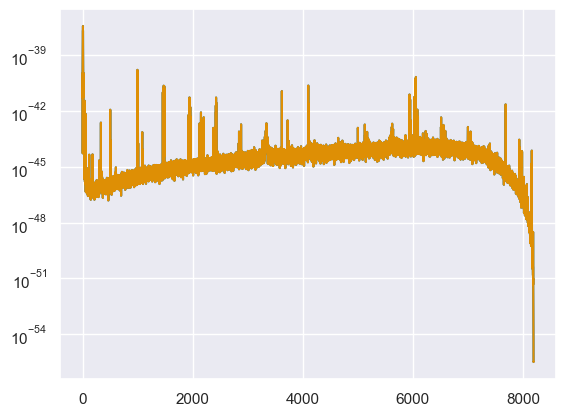

In [888]:
acf_new[0:4].to_psd().iloc[1:].plot()
acf_new.to_psd().iloc[1:].plot()
plt.yscale('log')

In [106]:
actual = 250
p = 50
small = np.percentile(results[0].posterior.gamma.values.flatten(),q=(100 - p)/2)
big = np.percentile(results[0].posterior.gamma.values.flatten(),q= 100-(100-p)/2)
gamma_ranges = [small,big]


thing = []
for p in [10,20,30,40,50,60,70,80,90]:
    for i, result in enumerate(results):
        small = np.percentile(result.posterior.gamma.values.flatten(),q=(100 - p)/2)
        big = np.percentile(result.posterior.gamma.values.flatten(),q= 100-(100-p)/2)
        is_inside = (actual > small) and (actual < big)
        thing.append({'run': i, 'confidence_interval': p/100, 'is_inside': is_inside})
        
df = pd.DataFrame(thing)

In [107]:
res = df.groupby('confidence_interval').is_inside.sum() / df.groupby('confidence_interval').is_inside.count()

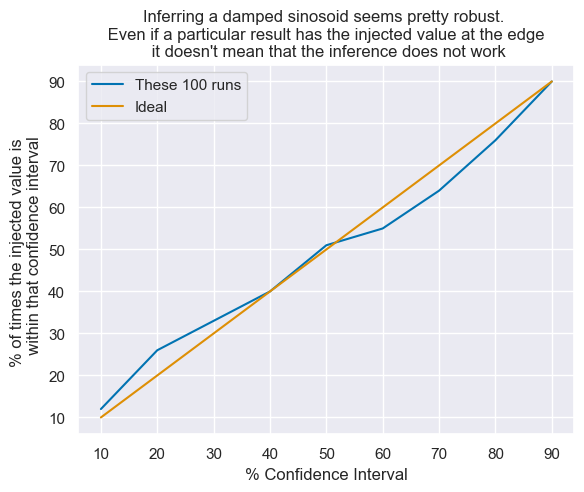

In [129]:
plt.plot(res.index*100, res.values*100, label="These 100 runs")
plt.plot(np.arange(0.1,1,0.1)*100,np.arange(0.1,1,0.1)*100, label="Ideal") 
plt.xlabel("% Confidence Interval")
plt.ylabel("% of times the injected value is \n  within that confidence interval")
plt.title("Inferring a damped sinosoid seems pretty robust. \n Even if a particular result has the injected value at the edge \n it doesn't mean that the inference does not work")
plt.legend()
plt.savefig("Damped-Sinosoid-Is-Robust.png")
plt.show()

### Testing the effect of conditioning

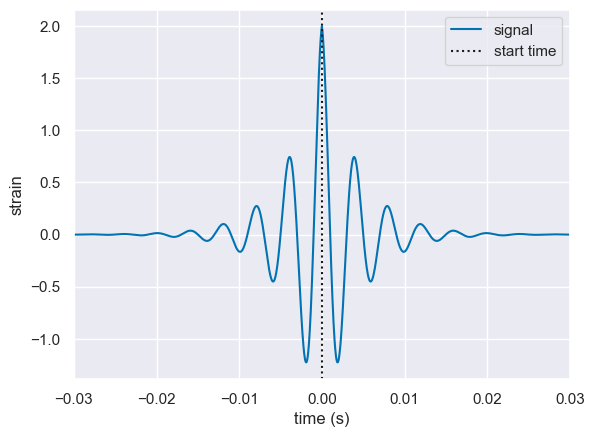

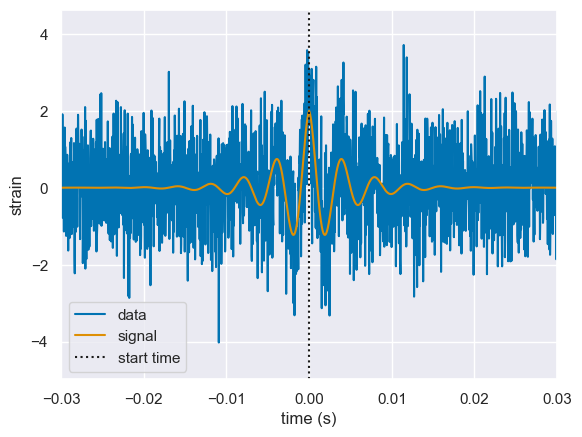

{'A_scale': 5, 'f_max': 500, 'f_min': 50, 'gamma_max': 500, 'gamma_min': 50}

In [96]:
from pylab import *
import arviz as az
import seaborn as sns
import pandas as pd
import ringdown as rd

sns.set(context='notebook', palette='colorblind')


# define sampling rate and duration (make these powers of two)
fsamp = 8192*4
duration = 4
t0 = 0

delta_t = 1/fsamp
tlen = int(round(duration / delta_t))
epoch = t0 - 0.5*tlen*delta_t

time = np.arange(tlen)*delta_t + epoch

wf_kws = dict(
    A = 2,
    phi = 0,
    f = 250,
    gamma = 250,
)

def get_signal(time, A, phi, f, gamma):
    s = A*cos(2*np.pi*f*(time-t0) + phi)*exp(-gamma*abs(time-t0))
    return rd.Data(s, index=time)

signal = get_signal(time, **wf_kws)

signal.plot(label='signal')
axvline(t0, ls=':', c='k', label='start time')
xlim(-0.03, 0.03)
xlabel('time (s)')
ylabel('strain')
legend();

plt.show()
#L = acf.cholesky

#rng = np.random.default_rng(12345)
#data = signal + np.random.multivariate_normal(mean=zeros_like(acf.values),cov=L@L.transpose())
data = signal + np.random.normal(0,1,len(signal))
#rng.normal(0, 1, len(signal))

data.plot(label='data')
signal.plot(label='signal')
axvline(t0, ls=':', c='k', label='start time')
xlim(-0.03, 0.03)
xlabel('time (s)')
ylabel('strain')
legend();

plt.show()


ds = 4
acf = rd.AutoCovariance(zeros_like(data), delta_t=data.delta_t)
acf.iloc[0] = 1/ds

fit = rd.Fit('ftau', modes=1)
fit.add_data(data, ifo='X')
fit.set_target(t0, duration=0.05)
fit.condition_data(ds=ds, digital_filter=True)
fit.compute_acfs()
fit.update_prior(A_scale=5, f_min=50, f_max=500, gamma_min=50, gamma_max=500)
fit.prior_settings




In [97]:
fit.run()

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f, gamma, Ax_unit, Ay_unit]
INFO:pymc:NUTS: [f, gamma, Ax_unit, Ay_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


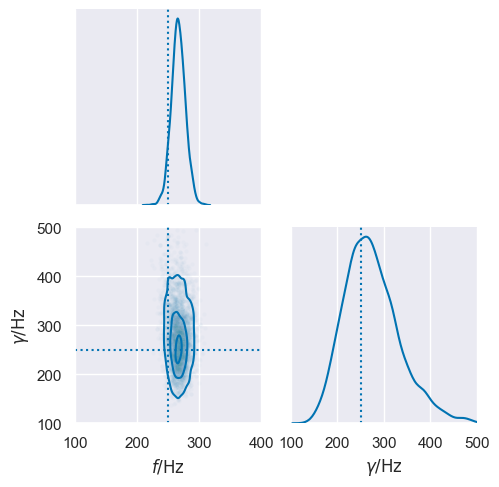

In [98]:
f_tau_plot(fit.result)

<AxesSubplot: >

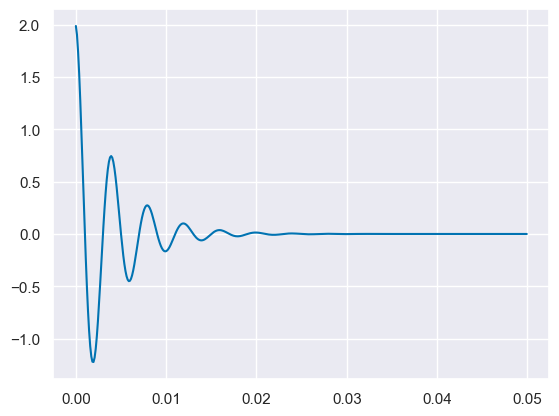

In [70]:
fit.analysis_data[None].plot()

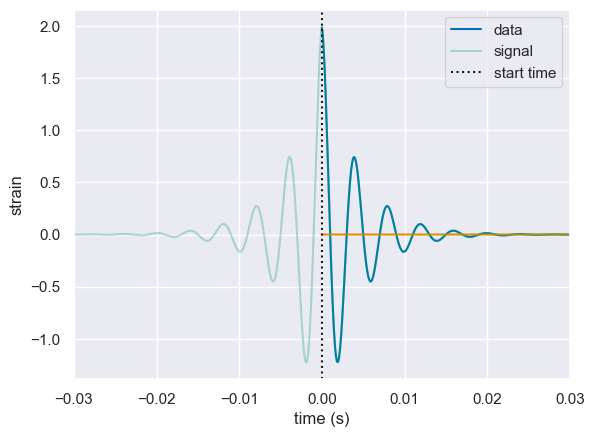

In [72]:
fit.analysis_data[None].plot(label='data')
L_new = fit.model_input['Ls'][0]
new_noise = ringdown.Data(np.random.multivariate_normal(mean=zeros_like(fit.analysis_data[None].values),
                                          cov=L_new.transpose()@L_new)
                          , index=fit.analysis_data[None].index ,ifo = 'X')

new_noise.plot()
signal.plot(label='signal', alpha=0.3)
axvline(t0, ls=':', c='k', label='start time')
xlim(-0.03, 0.03)
xlabel('time (s)')
ylabel('strain')
legend();

plt.show()

In [37]:
new_noise.mean()
print(new_noise.std())

print((data - signal)[0:0.03].std())

0.4966137773985985
1.017600565539766


In [15]:
np.diag(fit.model_input['Ls'][0] @ fit.model_input['Ls'][0].transpose())

array([0.25492046, 0.25492046, 0.25492046, 0.25492046, 0.25492046,
       0.25492046, 0.25492046, 0.25492046, 0.25492046, 0.25492046,
       0.25492046, 0.25492046, 0.25492046, 0.25492046, 0.25492046,
       0.25492046, 0.25492046, 0.25492046, 0.25492046, 0.25492046,
       0.25492046, 0.25492046, 0.25492046, 0.25492046, 0.25492046,
       0.25492046, 0.25492046, 0.25492046, 0.25492046, 0.25492046,
       0.25492046, 0.25492046, 0.25492046, 0.25492046, 0.25492046,
       0.25492046, 0.25492046, 0.25492046, 0.25492046, 0.25492046,
       0.25492046, 0.25492046, 0.25492046, 0.25492046, 0.25492046,
       0.25492046, 0.25492046, 0.25492046, 0.25492046, 0.25492046,
       0.25492046, 0.25492046, 0.25492046, 0.25492046, 0.25492046,
       0.25492046, 0.25492046, 0.25492046, 0.25492046, 0.25492046,
       0.25492046, 0.25492046, 0.25492046, 0.25492046, 0.25492046,
       0.25492046, 0.25492046, 0.25492046, 0.25492046, 0.25492046,
       0.25492046, 0.25492046, 0.25492046, 0.25492046, 0.25492

In [58]:
delta_t = 1/fsamp
tlen = int(round(duration / delta_t))
epoch = t0 - 0.5*tlen*delta_t

time = np.arange(tlen)*delta_t + epoch
# define sampling rate and duration (make these powers of two)
fsamp = 2**(14+2) #2**(14-2)
duration = 0.05
t0 = 0
mynoise = ringdown.Data(np.random.normal(0,1,len(time)), index=time, ifo="X")

In [59]:
print(f"The noise sequence has a standard deviation {mynoise.std()}")

The noise sequence has a standard deviation 1.041252197224224


In [130]:
L = mynoise.get_acf().cholesky
L # The choleksy matrix is good, and has 1s on the diagonal, great!

/Users/asadh/Documents/GitHub/ringdown-CLI/environments/notebook-venv/lib/python3.8/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 16384 is greater than input length  = 819, using nperseg = 819
  warnings.warn('nperseg = {0:d} is greater than input length '


array([[ 1.04783034,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00463684,  1.04782008,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01355379,  0.00457691,  1.04773268, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.02563658, -0.0143027 ,  0.01569955, ...,  0.53883042,
         0.        ,  0.        ],
       [ 0.01355379,  0.02557685, -0.0144775 , ..., -0.01254937,
         0.53858708,  0.        ],
       [ 0.00463684,  0.0135334 ,  0.02551986, ...,  0.01619209,
        -0.01217776,  0.53844939]])

In [79]:
mynoise.condition(ds=, digital_filter=True).std()

0.2396879247820465

In [139]:

event = db.event("GW150914")
event.strain()["H1"].index[0]

1126259447.0

# Real Event Injections

In [207]:
import scipy

def make_new_noise(noise):
    N = len(noise)
    dt = noise.index[1] - noise.index[0]

    x = noise.index
    y = noise.values

    yf = scipy.fft.fft(y)
    phase = np.copy(yf)

    phase[0] = 1
    phase[1:(N//2)] = np.exp( 1j*2*np.pi*np.random.rand(len(yf[1:N//2])) )
    phase[N//2] = 1
    phase[((N//2)+1):] = np.conjugate(np.flip(phase[1:(N//2)]))

    new_noise = scipy.fft.ifft(phase*yf)

    new_noise = ringdown.Data(new_noise.real, index=x)
    
    return new_noise

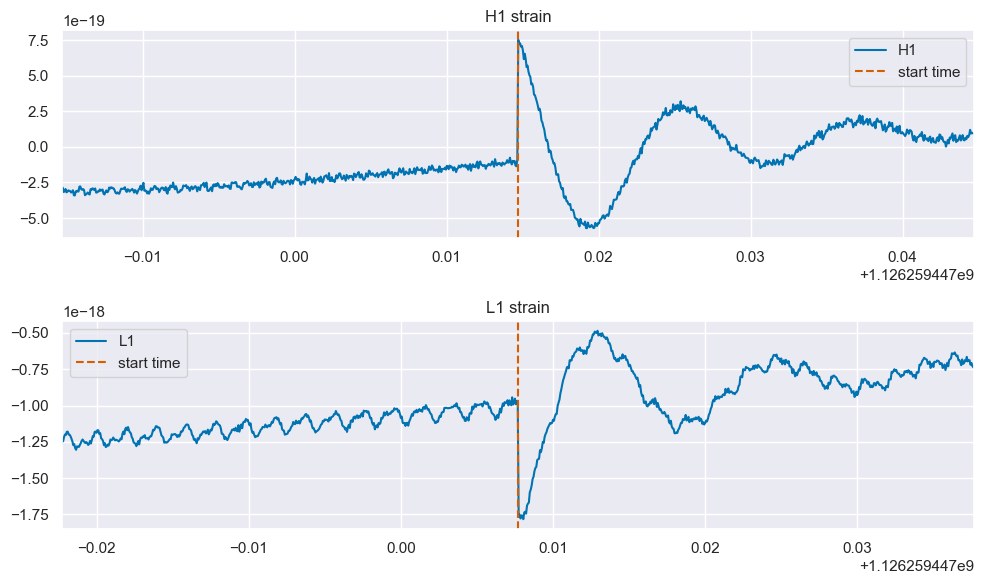

In [345]:
import lal

### Overall Params
params = {
    'model' : 'mchi',
    'a' : np.array([1e-18, 5e-19]),
    #'f' : [250, 260],
    #'tau': [1/250, 1/750],
    'M': 200,
    'chi': 0.7,
    'modes': [(1,-2,2,2,0), (1,-2,2,2,1)],
    'theta': 0,
    'ellip': 0.5,
    'phi' : 0,
    'ra' : 1.95,
    'dec': -1.27,
    'psi': 0.82
}

### Choose detectors
detectors = ["H1","L1"]

### Get the real strain for GW150914
real_strain = {}
for ifo in detectors:
    real_strain[ifo] = event.strain()[ifo]

### Initial reference time for the sky location mapping
t_ref = h1.index[0]

### Calculate time delays
time_delay_dict = {}
for ifo in detectors:
    time_delay_dict[ifo] = lal.TimeDelayFromEarthCenter(lal.cached_detector_by_prefix[ifo].location,
                                                        params["ra"], params["dec"], 
                                                        t_ref)

    
### Create the signal from the above parameters
fsamp = int(real_strain["H1"].fsamp)
time = np.arange(-2,2,1/(fsamp)) + t_ref
signal = ringdown.Ringdown.from_parameters(time=time, t0=t_ref, **params)

### Project the signals onto the detectors
strain = {}
for ifo in detectors:
    strain[ifo] = signal.project(ifo=ifo,t0=t_ref, delay=time_delay_dict[ifo],
                                 ra=params['ra'],dec=params['dec'], psi=params['psi'])

### Mimic the noise from the original detectors
noise_strain = {}
for ifo in detectors:
    strain[ifo]
    noise_strain[ifo] = make_new_noise(real_strain[ifo]).iloc[initial_index:(initial_index + len(strain[ifo]))]
    noise_strain[ifo].index = strain[ifo].index
    
### Synthetic Strain creation
injection = {}
for ifo in detectors:
    t0 = t_ref + time_delay_dict[ifo]
    strain[ifo][strain[ifo].index < t0] = 0
    injection[ifo] = strain[ifo] + noise_strain[ifo]
    

fig, axes = plt.subplots(nrows=2, figsize= (10,6))
for i,ifo in enumerate(detectors):
    injection[ifo].plot(ax=axes[i], label=ifo)
    axes[i].set_title(ifo + " strain")
    axes[i].set_xlim((t_ref + time_delay_dict[ifo] - 0.03, t_ref + time_delay_dict[ifo] + 0.03))
    axes[i].axvline(t_ref + time_delay_dict[ifo], color='r', linestyle='--', label="start time")
    axes[i].legend()
    
plt.tight_layout()

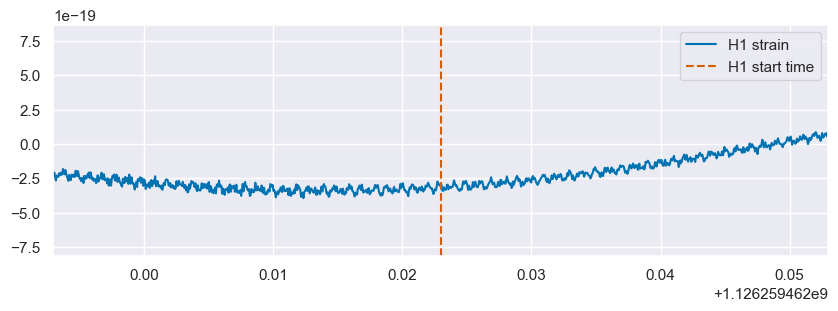

In [346]:
fig, axes = plt.subplots(nrows=1, figsize= (10,3))
real_strain["H1"].plot(ax=axes, label="H1 strain")

mid_point = 1126259462.423
axes.set_xlim((mid_point - 0.03, mid_point + 0.03))

axes.axvline(mid_point, color='r', linestyle="--", label="H1 start time")
plt.legend()
plt.show()

# Analyze our injection

In [347]:
## Set our target
target = {'t0': t_ref, 
          'ra': params['ra'],
          'dec': params['dec'],
          'psi': params['psi']}

duration = 0.05

fit = ringdown.Fit(model='mchi', modes=[(1,-2,2,2,0), (1,-2,2,2,1)])

for ifo in detectors:
    fit.add_data(injection[ifo], ifo=ifo)
    
sample_rate = np.max([f.fsamp for f in injection.values()])
target_sample_rate = 4096

fit.set_target(**target, duration=duration)

#Adding a cond kwargs to allow us to low pass or add other conditioning arguments
cond_kws = {'flow': 20.0}
default_kws = dict(digital_filter=True)
default_kws.update(cond_kws or {})

fit.condition_data(ds=int(sample_rate/target_sample_rate),**default_kws)
fit.compute_acfs()

mass_for_prior = 200
fit.update_prior(A_scale=5e-18, M_min=mass_for_prior*0.5,
                     M_max=mass_for_prior*2.0,
                     flat_A=1)


In [348]:
fit.run()

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, Apx_unit, Apy_unit, Acx_unit, Acy_unit, df, dtau]
INFO:pymc:NUTS: [M, chi, Apx_unit, Apy_unit, Acx_unit, Acy_unit, df, dtau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 158 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 158 seconds.


In [349]:
import qnm
import lal
import numpy as np
T_MSUN = lal.MSUN_SI * lal.G_SI / lal.C_SI**3
q220 = qnm.modes_cache(-2, 2, 2, 0)
q221 = qnm.modes_cache(-2,2,2,1)

def get_fgamma(M, chi, n, l=2, m=2):
    if n == 0:
        omega, _, _ = q220(a=chi)
    else:
        omega, _, _ = q221(a=chi)
    f = np.real(omega)/(2* np.pi) / (T_MSUN*M)
    gamma = abs(np.imag(omega)) / (T_MSUN*M)
    return f, gamma

In [350]:
az.summary(fit.result, var_names=['f','gamma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
f[b'1220'],81.648,0.060,81.540,81.761,0.001,0.000,7277.0,3174.0,1.0
f[b'1221'],77.751,0.078,77.607,77.900,0.001,0.001,7506.0,3120.0,1.0
gamma[b'1220'],105.088,0.322,104.447,105.676,0.004,0.003,6486.0,2901.0,1.0
gamma[b'1221'],320.698,1.033,318.644,322.583,0.013,0.009,6503.0,2923.0,1.0


array([[<AxesSubplot: title={'center': 'M'}>,
        <AxesSubplot: title={'center': 'M'}>],
       [<AxesSubplot: title={'center': 'chi'}>,
        <AxesSubplot: title={'center': 'chi'}>]], dtype=object)

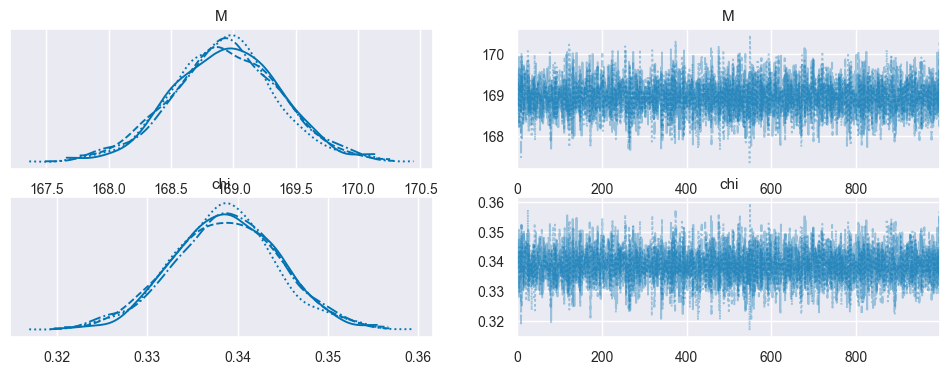

In [351]:
az.plot_trace(fit.result, var_names=['M','chi'])

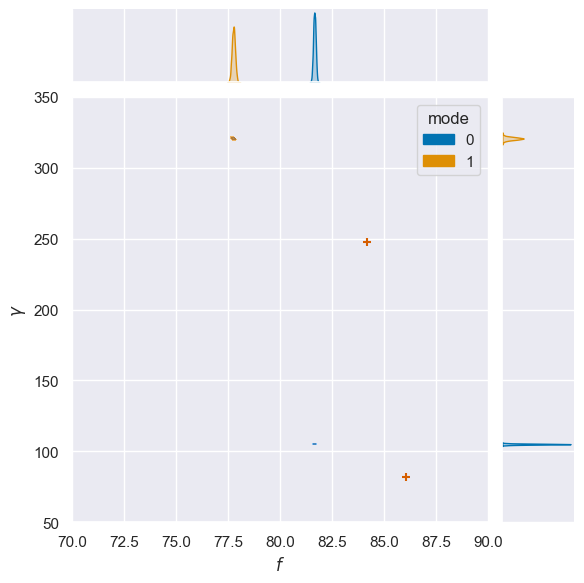

In [353]:
mode0 = pd.DataFrame({
    r'$f$' : fit.result.posterior.f.values[:,:,0].flatten(),
    r'$\gamma$' : fit.result.posterior.gamma.values[:,:,0].flatten(),
    'mode': 0
})

mode1 = pd.DataFrame({
    r'$f$' : fit.result.posterior.f.values[:,:,1].flatten(),
    r'$\gamma$' : fit.result.posterior.gamma.values[:,:,1].flatten(),
    'mode': 1
})

mode_df = pd.concat([mode0, mode1])

g = sns.jointplot(data=mode_df, x=r'$f$', y=r'$\gamma$', hue='mode',
              kind='kde', fill=True, levels=[0.3,0.6,0.99],common_norm=False, alpha=0.7,
                     xlim=(70,90), ylim=(50,350));


M_true = params["M"]
chi_true = params["chi"]

f0_true, gamma0_true = get_fgamma(M_true, chi_true, 0)
f1_true, gamma1_true = get_fgamma(M_true, chi_true, 1)

g.ax_joint.scatter([f0_true, f1_true],[gamma0_true, gamma1_true], marker='+', color='r', label="True")

g